In [4]:
# Imports nécessaires - base
import polars as pl
import numpy as np

In [5]:
import mlflow
# 1. Chargement du Meilleur Modèle
# Configurations MLflow
experiment_name = "mega_evolution_optimization"
model_name = "GradientBoostingChain"

# Récupérer le meilleur run
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    print(f"Expérience '{experiment_name}' non trouvée. Vérifiez le nom.")
else:
    experiment_id = experiment.experiment_id

    # Trouver le meilleur run en se basant sur la métrique moyenne
    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        filter_string="tags.mlflow.runName = 'Final_Model_Evaluation'",
        order_by=["metrics.average_RMSE ASC"]
    )
    
    if len(runs) > 0:
        best_run = runs.iloc[0]
        print(f"Meilleur run trouvé: {best_run.run_id}")
        print(f"RMSE moyen: {best_run['metrics.average_RMSE']:.2f}")
        print(f"R² moyen: {best_run['metrics.average_R2']:.2f}")
        
        # Charger le modèle
        best_model_uri = f"runs:/{best_run.run_id}/final_model"
        best_model = mlflow.sklearn.load_model(best_model_uri)
        print("\nModèle chargé avec succès!")
    else:
        print("Aucun run trouvé avec le nom 'Final_Model_Evaluation'. Vérifiez vos runs MLflow.")

Meilleur run trouvé: d1460e0e726644a0adf2c784b4679cb4
RMSE moyen: 19.21
R² moyen: 0.55

Modèle chargé avec succès!


In [6]:
# Imports pour preprocessing
from sklearn.preprocessing import StandardScaler
# 2. Préparation du Modèle de Production
# Charger les données pour entraîner les scalers
silver_df = pl.read_csv('../data/silver_mega_evolutions.csv')

# Définir les colonnes cibles et d'entrée
target_cols = [
    'evolved_attack', 'evolved_defense', 
    'evolved_sp_attack', 'evolved_sp_defense', 'evolved_speed'
]

input_cols = [col for col in silver_df.columns if col.startswith('base_')]

# Préparer X et y
X = silver_df.select(input_cols).to_numpy()
y = silver_df.select(target_cols).to_numpy()

# Standardiser les données
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Afficher les informations sur les données
print(f"Nombre de Pokémon dans les données: {X.shape[0]}")
print(f"Nombre de caractéristiques d'entrée: {X.shape[1]}")
print(f"Nombre de caractéristiques de sortie: {y.shape[1]}")

Nombre de Pokémon dans les données: 48
Nombre de caractéristiques d'entrée: 9
Nombre de caractéristiques de sortie: 5


In [7]:
# Import pour sauvegarde
import joblib
import os

In [8]:
# 3. Fonction simple de prédiction
def predict_evolution(pokemon_dict, model, scaler_X, scaler_y, input_cols, target_cols):
    """
    Prédit les stats d'évolution d'un Pokémon.
    
    Args:
        pokemon_dict: Dictionnaire contenant les caractéristiques de base du Pokémon
        model: Modèle entraîné
        scaler_X: Standardiseur des caractéristiques
        scaler_y: Standardiseur des cibles
        input_cols: Liste des colonnes d'entrée
        target_cols: Liste des colonnes cibles
    
    Returns:
        Dictionnaire avec les stats prédites pour l'évolution
    """
    # Vérifier que toutes les features nécessaires sont présentes
    for col in input_cols:
        if col not in pokemon_dict:
            raise ValueError(f"Feature manquante: {col}")
    
    # Préparer les features dans le bon ordre
    X = np.array([[pokemon_dict[col] for col in input_cols]])
    
    # Standardiser
    X_scaled = scaler_X.transform(X)
    
    # Prédire
    y_scaled = model.predict(X_scaled)
    
    # Dé-standardiser
    y_pred = scaler_y.inverse_transform(y_scaled.reshape(1, -1))[0]
    
    # Convertir en dictionnaire
    predictions = {}
    for i, col in enumerate(target_cols):
        stat_name = col.replace('evolved_', '')
        predictions[stat_name] = int(round(y_pred[i]))  # Arrondir pour des stats entières
    
    return predictions

# Sauvegarder le modèle et les scalers
os.makedirs('../models', exist_ok=True)
joblib.dump(best_model, '../models/evolution_model.joblib')
joblib.dump(scaler_X, '../models/evolution_scaler_X.joblib')
joblib.dump(scaler_y, '../models/evolution_scaler_y.joblib')

# Sauvegarder les noms de colonnes
import json
column_info = {
    "input_cols": input_cols,
    "target_cols": target_cols
}
with open('../models/evolution_columns.json', 'w') as f:
    json.dump(column_info, f)

print("Modèle et composants sauvegardés dans le dossier '../models/'")

Modèle et composants sauvegardés dans le dossier '../models/'


In [1]:
# Imports nécessaires
import polars as pl
import numpy as np
import joblib
import os
import json
import mlflow
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement du Meilleur Modèle
# Configurations MLflow
experiment_name = "mega_evolution_optimization"
model_name = "GradientBoostingChain"

# Récupérer le meilleur run
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    print(f"Expérience '{experiment_name}' non trouvée. Vérifiez le nom.")
else:
    experiment_id = experiment.experiment_id

    # Trouver le meilleur run en se basant sur la métrique moyenne
    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        filter_string="tags.mlflow.runName = 'Final_Model_Evaluation'",
        order_by=["metrics.average_RMSE ASC"]
    )
    
    if len(runs) > 0:
        best_run = runs.iloc[0]
        print(f"Meilleur run trouvé: {best_run.run_id}")
        print(f"RMSE moyen: {best_run['metrics.average_RMSE']:.2f}")
        print(f"R² moyen: {best_run['metrics.average_R2']:.2f}")
        
        # Charger le modèle
        best_model_uri = f"runs:/{best_run.run_id}/final_model"
        best_model = mlflow.sklearn.load_model(best_model_uri)
        print("\nModèle chargé avec succès!")
    else:
        print("Aucun run trouvé avec le nom 'Final_Model_Evaluation'. Vérifiez vos runs MLflow.")

Meilleur run trouvé: d1460e0e726644a0adf2c784b4679cb4
RMSE moyen: 19.21
R² moyen: 0.55

Modèle chargé avec succès!


In [3]:
# 2. Préparation du Modèle de Production
# Charger les données pour entraîner les scalers
silver_df = pl.read_csv('../data/silver_mega_evolutions.csv')

# Définir les colonnes cibles et d'entrée
target_cols = [
    'evolved_attack', 'evolved_defense', 
    'evolved_sp_attack', 'evolved_sp_defense', 'evolved_speed'
]

input_cols = [col for col in silver_df.columns if col.startswith('base_')]

# Préparer X et y
X = silver_df.select(input_cols).to_numpy()
y = silver_df.select(target_cols).to_numpy()

# Standardiser les données
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Afficher les informations sur les données
print(f"Nombre de Pokémon dans les données: {X.shape[0]}")
print(f"Nombre de caractéristiques d'entrée: {X.shape[1]}")
print(f"Nombre de caractéristiques de sortie: {y.shape[1]}")

Nombre de Pokémon dans les données: 48
Nombre de caractéristiques d'entrée: 9
Nombre de caractéristiques de sortie: 5


In [9]:
# 4. Tester le Modèle avec Quelques Exemples
# Créer un exemple de Pokémon
charizard = {
    'base_hp': 78,
    'base_attack': 84,
    'base_defense': 78,
    'base_sp_attack': 109,
    'base_sp_defense': 85,
    'base_speed': 100,
    'base_experience': 267,
    'base_height': 17,
    'base_weight': 905
}

blastoise = {
    'base_hp': 79,
    'base_attack': 83,
    'base_defense': 100,
    'base_sp_attack': 85,
    'base_sp_defense': 105,
    'base_speed': 78,
    'base_experience': 265,
    'base_height': 16,
    'base_weight': 855
}

# Prédire les stats d'évolution
charizard_mega = predict_evolution(charizard, best_model, scaler_X, scaler_y, input_cols, target_cols)
blastoise_mega = predict_evolution(blastoise, best_model, scaler_X, scaler_y, input_cols, target_cols)

# Afficher les prédictions
print("Charizard → Mega Charizard (Prédit):")
for stat, value in charizard_mega.items():
    print(f"  {stat}: {value}")

print("\nBlastoise → Mega Blastoise (Prédit):")
for stat, value in blastoise_mega.items():
    print(f"  {stat}: {value}")

Charizard → Mega Charizard (Prédit):
  attack: 110
  defense: 91
  sp_attack: 146
  sp_defense: 92
  speed: 112

Blastoise → Mega Blastoise (Prédit):
  attack: 113
  defense: 112
  sp_attack: 130
  sp_defense: 110
  speed: 81


In [11]:
# 4.5 Comparer avec les vraies valeurs d'évolution
def find_pokemon_in_df(df, base_stats, epsilon=5):
    """Trouve un Pokémon dans le dataframe qui correspond approximativement aux stats de base données"""
    matches = []
    
    for idx in range(len(df)):
        match = True
        for col in input_cols:
            if abs(df[col][idx] - base_stats[col]) > epsilon:
                match = False
                break
        if match:
            matches.append(idx)
    
    return matches

# Trouver des Pokémon correspondants dans notre dataset
charizard_matches = find_pokemon_in_df(silver_df, charizard)
blastoise_matches = find_pokemon_in_df(silver_df, blastoise)

# Fonction pour comparer les prédictions avec la réalité
def compare_prediction_vs_actual(pokemon_name, base_stats, predicted_stats, df_idx=None):
    print(f"\n=== {pokemon_name} ===")
    
    # Si on a trouvé une correspondance dans le dataset
    if df_idx is not None:
        actual_stats = {}
        for col in target_cols:
            stat_name = col.replace('evolved_', '')
            actual_stats[stat_name] = int(silver_df[col][df_idx])
        
        # Afficher la comparaison
        print(f"{'Statistique':<12} {'Base':<6} {'Prédiction':<10} {'Réelle':<6} {'Erreur':<6}")
        print("-" * 45)
        
        total_error = 0
        for stat in ['attack', 'defense', 'sp_attack', 'sp_defense', 'speed']:
            base_val = base_stats[f'base_{stat}']
            pred_val = predicted_stats[stat]
            real_val = actual_stats[stat]
            error = pred_val - real_val
            total_error += abs(error)
            
            print(f"{stat:<12} {base_val:<6} {pred_val:<10} {real_val:<6} {error:>6}")
        
        print("-" * 45)
        print(f"Erreur absolue moyenne: {total_error/5:.1f}")
        
        return actual_stats
    else:
        # Si aucune correspondance trouvée, juste afficher la prédiction
        print(f"Aucune correspondance trouvée dans le dataset pour {pokemon_name}")
        print(f"{'Statistique':<12} {'Base':<6} {'Prédiction':<10}")
        print("-" * 30)
        
        for stat in ['attack', 'defense', 'sp_attack', 'sp_defense', 'speed']:
            base_val = base_stats[f'base_{stat}']
            pred_val = predicted_stats[stat]
            
            print(f"{stat:<12} {base_val:<6} {pred_val:<10}")
        
        return None

# Comparer les prédictions avec les valeurs réelles
charizard_actual = None
if charizard_matches:
    charizard_actual = compare_prediction_vs_actual("Charizard", charizard, charizard_mega, charizard_matches[0])
else:
    compare_prediction_vs_actual("Charizard", charizard, charizard_mega)

blastoise_actual = None
if blastoise_matches:
    blastoise_actual = compare_prediction_vs_actual("Blastoise", blastoise, blastoise_mega, blastoise_matches[0])
else:
    compare_prediction_vs_actual("Blastoise", blastoise, blastoise_mega)


=== Charizard ===
Statistique  Base   Prédiction Réelle Erreur
---------------------------------------------
attack       84     110        130       -20
defense      78     91         111       -20
sp_attack    109    146        130        16
sp_defense   85     92         85          7
speed        100    112        100        12
---------------------------------------------
Erreur absolue moyenne: 15.0

=== Blastoise ===
Statistique  Base   Prédiction Réelle Erreur
---------------------------------------------
attack       83     113        103        10
defense      100    112        120        -8
sp_attack    85     130        135        -5
sp_defense   105    110        115        -5
speed        78     81         78          3
---------------------------------------------
Erreur absolue moyenne: 6.2


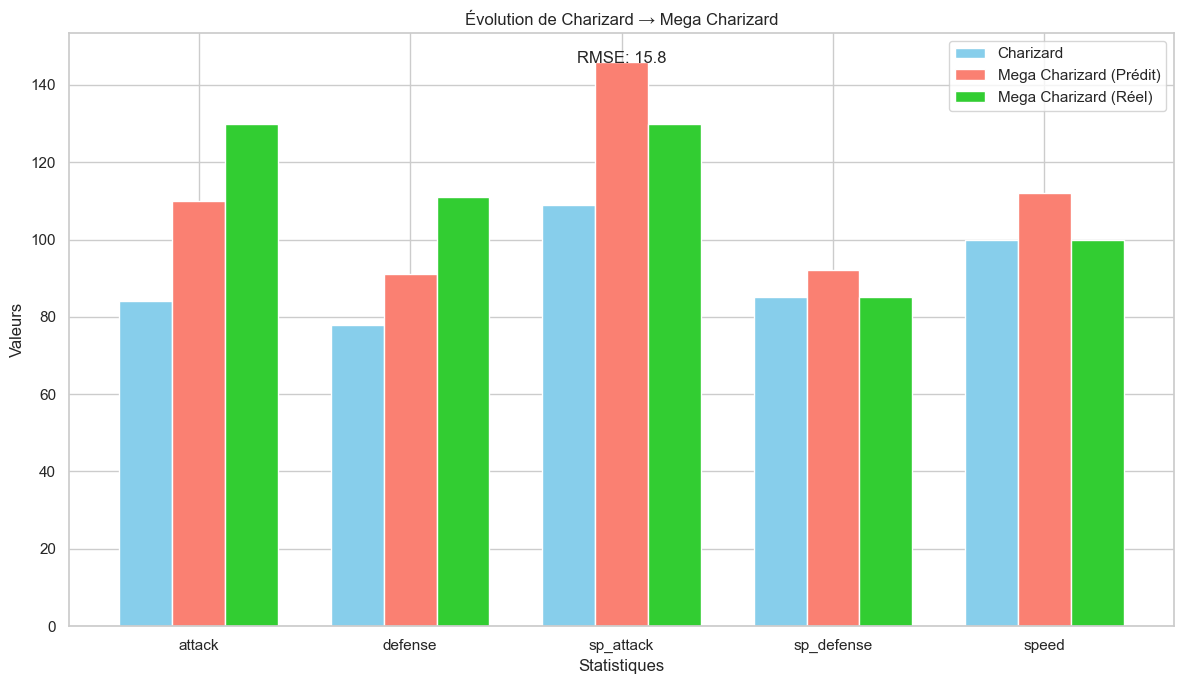

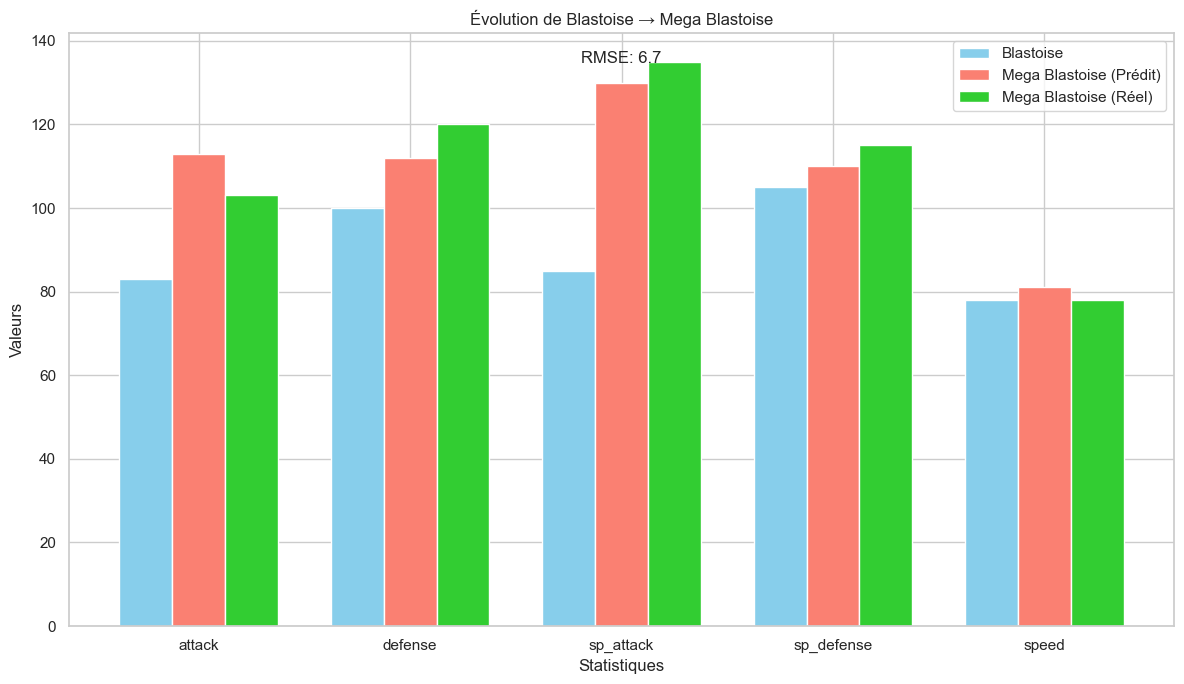

In [12]:
# 5. Visualiser les changements
def plot_evolution_comparison(base_stats, mega_stats, actual_stats=None, name="Pokémon"):
    stats = ['attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
    
    base_values = [base_stats[f'base_{stat}'] for stat in stats]
    mega_values = [mega_stats[stat] for stat in stats]
    
    x = range(len(stats))
    width = 0.25  # Réduire la largeur pour accommoder une troisième barre
    
    plt.figure(figsize=(12, 7))
    sns.set(style='whitegrid')
    
    plt.bar(x, base_values, width, label=f'{name}', color='skyblue')
    plt.bar([i + width for i in x], mega_values, width, label=f'Mega {name} (Prédit)', color='salmon')
    
    # Si nous avons les valeurs réelles, les ajouter
    if actual_stats:
        actual_values = [actual_stats[stat] for stat in stats]
        plt.bar([i + width*2 for i in x], actual_values, width, label=f'Mega {name} (Réel)', color='limegreen')
        
        # Calculer et afficher le RMSE
        rmse = np.sqrt(np.mean([(mega_values[i] - actual_values[i])**2 for i in range(len(stats))]))
        plt.text(0.5, 0.95, f'RMSE: {rmse:.1f}', transform=plt.gca().transAxes, ha='center')
    
    plt.xlabel('Statistiques')
    plt.ylabel('Valeurs')
    plt.title(f'Évolution de {name} → Mega {name}')
    
    # Ajuster la position des étiquettes en fonction du nombre de barres
    if actual_stats:
        plt.xticks([i + width for i in x], stats)
    else:
        plt.xticks([i + width/2 for i in x], stats)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualiser l'évolution pour Charizard et Blastoise
plot_evolution_comparison(charizard, charizard_mega, charizard_actual, 'Charizard')
plot_evolution_comparison(blastoise, blastoise_mega, blastoise_actual, 'Blastoise')

In [ ]:
results = {}

for name, model in models.items():
    print(f"\nEntraînement de {name}...")
    
    # Démarrer un run MLflow
    with mlflow.start_run(run_name=name):
        # Entraînement
        model.fit(X_train_scaled, y_train_scaled)
        
        # Prédictions
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test_scaled)
        
        # Évaluation
        metrics = {}
        rmse_values = []
        r2_values = []
        
        for i, col in enumerate(target_cols):
            stat_name = col.replace('evolved_', '')
            rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
            r2 = r2_score(y_true[:, i], y_pred[:, i])
            
            # Collecter les valeurs pour calculer les moyennes
            rmse_values.append(rmse)
            r2_values.append(r2)
            
            # Enregistrer les métriques dans MLflow
            mlflow.log_metric(f"{stat_name}_RMSE", rmse)
            mlflow.log_metric(f"{stat_name}_R2", r2)
            
            metrics[stat_name] = {"RMSE": rmse, "R²": r2}
        
        # Calculer et enregistrer les métriques moyennes
        avg_rmse = np.mean(rmse_values)
        avg_r2 = np.mean(r2_values)
        
        mlflow.log_metric("average_RMSE", avg_rmse)
        mlflow.log_metric("average_R2", avg_r2)
        
        # Ajouter les moyennes aux métriques
        metrics["Average"] = {"RMSE": avg_rmse, "R²": avg_r2}
        
        # Créer la signature du modèle
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train_scaled, y_train_scaled)
        
        # Log du modèle dans MLflow avec signature
        mlflow.sklearn.log_model(model, name, signature=signature)
        
        # Afficher les résultats
        print(f"Résultats pour {name}:")
        for stat, vals in metrics.items():
            print(f"  {stat}: RMSE = {vals['RMSE']:.2f}, R² = {vals['R²']:.2f}")
        
        # Mettre en évidence la métrique globale
        print(f"  --> Moyenne globale: RMSE = {avg_rmse:.2f}, R² = {avg_r2:.2f}")
        
        results[name] = metrics


Entraînement de Decision Tree...


Résultats pour Decision Tree:
  attack: RMSE = 26.82, R² = 0.46
  defense: RMSE = 31.84, R² = -0.12
  sp_attack: RMSE = 41.14, R² = 0.05
  sp_defense: RMSE = 16.83, R² = 0.19
  speed: RMSE = 45.94, R² = -0.16
  Average: RMSE = 32.51, R² = 0.08
  --> Moyenne globale: RMSE = 32.51, R² = 0.08

Entraînement de Random Forest...
Résultats pour Random Forest:
  attack: RMSE = 23.96, R² = 0.57
  defense: RMSE = 23.65, R² = 0.38
  sp_attack: RMSE = 29.65, R² = 0.51
  sp_defense: RMSE = 17.03, R² = 0.17
  speed: RMSE = 32.72, R² = 0.41
  Average: RMSE = 25.40, R² = 0.41
  --> Moyenne globale: RMSE = 25.40, R² = 0.41

Entraînement de Gradient Boosting...
Résultats pour Gradient Boosting:
  attack: RMSE = 24.38, R² = 0.55
  defense: RMSE = 22.29, R² = 0.45
  sp_attack: RMSE = 14.35, R² = 0.88
  sp_defense: RMSE = 17.86, R² = 0.09
  speed: RMSE = 18.76, R² = 0.81
  Average: RMSE = 19.53, R² = 0.56
  --> Moyenne globale: RMSE = 19.53, R² = 0.56

Entraînement de Gradient Boosting Chain...
Résultats p

In [ ]:
results = {}

for name, model in models.items():
    print(f"\nEntraînement de {name}...")
    
    # Démarrer un run MLflow
    with mlflow.start_run(run_name=name):
        # Entraînement
        model.fit(X_train_scaled, y_train_scaled)
        
        # Prédictions
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test_scaled)
        
        # Évaluation
        metrics = {}
        rmse_values = []
        r2_values = []
        
        for i, col in enumerate(target_cols):
            stat_name = col.replace('evolved_', '')
            rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
            r2 = r2_score(y_true[:, i], y_pred[:, i])
            
            # Collecter les valeurs pour calculer les moyennes
            rmse_values.append(rmse)
            r2_values.append(r2)
            
            # Enregistrer les métriques dans MLflow
            mlflow.log_metric(f"{stat_name}_RMSE", rmse)
            mlflow.log_metric(f"{stat_name}_R2", r2)
            
            metrics[stat_name] = {"RMSE": rmse, "R²": r2}
        
        # Calculer et enregistrer les métriques moyennes
        avg_rmse = np.mean(rmse_values)
        avg_r2 = np.mean(r2_values)
        
        mlflow.log_metric("average_RMSE", avg_rmse)
        mlflow.log_metric("average_R2", avg_r2)
        
        # Ajouter les moyennes aux métriques
        metrics["Average"] = {"RMSE": avg_rmse, "R²": avg_r2}
        
        # Créer la signature du modèle
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train_scaled, y_train_scaled)
        
        # Log du modèle dans MLflow avec signature
        mlflow.sklearn.log_model(model, name, signature=signature)
        
        # Afficher les résultats
        print(f"Résultats pour {name}:")
        for stat, vals in metrics.items():
            print(f"  {stat}: RMSE = {vals['RMSE']:.2f}, R² = {vals['R²']:.2f}")
        
        # Mettre en évidence la métrique globale
        print(f"  --> Moyenne globale: RMSE = {avg_rmse:.2f}, R² = {avg_r2:.2f}")
        
        results[name] = metrics


Entraînement de Decision Tree...


Résultats pour Decision Tree:
  attack: RMSE = 26.82, R² = 0.46
  defense: RMSE = 31.84, R² = -0.12
  sp_attack: RMSE = 41.14, R² = 0.05
  sp_defense: RMSE = 16.83, R² = 0.19
  speed: RMSE = 45.94, R² = -0.16
  Average: RMSE = 32.51, R² = 0.08
  --> Moyenne globale: RMSE = 32.51, R² = 0.08

Entraînement de Random Forest...
Résultats pour Random Forest:
  attack: RMSE = 23.96, R² = 0.57
  defense: RMSE = 23.65, R² = 0.38
  sp_attack: RMSE = 29.65, R² = 0.51
  sp_defense: RMSE = 17.03, R² = 0.17
  speed: RMSE = 32.72, R² = 0.41
  Average: RMSE = 25.40, R² = 0.41
  --> Moyenne globale: RMSE = 25.40, R² = 0.41

Entraînement de Gradient Boosting...
Résultats pour Gradient Boosting:
  attack: RMSE = 24.38, R² = 0.55
  defense: RMSE = 22.29, R² = 0.45
  sp_attack: RMSE = 14.35, R² = 0.88
  sp_defense: RMSE = 17.86, R² = 0.09
  speed: RMSE = 18.76, R² = 0.81
  Average: RMSE = 19.53, R² = 0.56
  --> Moyenne globale: RMSE = 19.53, R² = 0.56

Entraînement de Gradient Boosting Chain...
Résultats p

In [ ]:
results = {}

for name, model in models.items():
    print(f"\nEntraînement de {name}...")
    
    # Démarrer un run MLflow
    with mlflow.start_run(run_name=name):
        # Entraînement
        model.fit(X_train_scaled, y_train_scaled)
        
        # Prédictions
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test_scaled)
        
        # Évaluation
        metrics = {}
        rmse_values = []
        r2_values = []
        
        for i, col in enumerate(target_cols):
            stat_name = col.replace('evolved_', '')
            rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
            r2 = r2_score(y_true[:, i], y_pred[:, i])
            
            # Collecter les valeurs pour calculer les moyennes
            rmse_values.append(rmse)
            r2_values.append(r2)
            
            # Enregistrer les métriques dans MLflow
            mlflow.log_metric(f"{stat_name}_RMSE", rmse)
            mlflow.log_metric(f"{stat_name}_R2", r2)
            
            metrics[stat_name] = {"RMSE": rmse, "R²": r2}
        
        # Calculer et enregistrer les métriques moyennes
        avg_rmse = np.mean(rmse_values)
        avg_r2 = np.mean(r2_values)
        
        mlflow.log_metric("average_RMSE", avg_rmse)
        mlflow.log_metric("average_R2", avg_r2)
        
        # Ajouter les moyennes aux métriques
        metrics["Average"] = {"RMSE": avg_rmse, "R²": avg_r2}
        
        # Créer la signature du modèle
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train_scaled, y_train_scaled)
        
        # Log du modèle dans MLflow avec signature
        mlflow.sklearn.log_model(model, name, signature=signature)
        
        # Afficher les résultats
        print(f"Résultats pour {name}:")
        for stat, vals in metrics.items():
            print(f"  {stat}: RMSE = {vals['RMSE']:.2f}, R² = {vals['R²']:.2f}")
        
        # Mettre en évidence la métrique globale
        print(f"  --> Moyenne globale: RMSE = {avg_rmse:.2f}, R² = {avg_r2:.2f}")
        
        results[name] = metrics


Entraînement de Decision Tree...


Résultats pour Decision Tree:
  attack: RMSE = 26.82, R² = 0.46
  defense: RMSE = 31.84, R² = -0.12
  sp_attack: RMSE = 41.14, R² = 0.05
  sp_defense: RMSE = 16.83, R² = 0.19
  speed: RMSE = 45.94, R² = -0.16
  Average: RMSE = 32.51, R² = 0.08
  --> Moyenne globale: RMSE = 32.51, R² = 0.08

Entraînement de Random Forest...
Résultats pour Random Forest:
  attack: RMSE = 23.96, R² = 0.57
  defense: RMSE = 23.65, R² = 0.38
  sp_attack: RMSE = 29.65, R² = 0.51
  sp_defense: RMSE = 17.03, R² = 0.17
  speed: RMSE = 32.72, R² = 0.41
  Average: RMSE = 25.40, R² = 0.41
  --> Moyenne globale: RMSE = 25.40, R² = 0.41

Entraînement de Gradient Boosting...
Résultats pour Gradient Boosting:
  attack: RMSE = 24.38, R² = 0.55
  defense: RMSE = 22.29, R² = 0.45
  sp_attack: RMSE = 14.35, R² = 0.88
  sp_defense: RMSE = 17.86, R² = 0.09
  speed: RMSE = 18.76, R² = 0.81
  Average: RMSE = 19.53, R² = 0.56
  --> Moyenne globale: RMSE = 19.53, R² = 0.56

Entraînement de Gradient Boosting Chain...
Résultats p